# Part 2 : EDA of Data Extracted from Job Postings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

from sqlalchemy import create_engine, MetaData, Table, select
from wordcloud import WordCloud

## Load Data

To explore data, first data needs to be loaded from sqlite database.

In [2]:
# import data from sqlite database
engine = create_engine("sqlite:///joblist.sqlite")
metadata = MetaData()
data = Table('data', metadata, autoload=True, autoload_with=engine)

print(repr(data))

Table('data', MetaData(), Column('jobtitle', VARCHAR(length=100), table=<data>), Column('company', VARCHAR(length=100), table=<data>), Column('location', VARCHAR(length=25), table=<data>), Column('salary', INTEGER(), table=<data>), Column('jobdescription', TEXT(), table=<data>), Column('label', INTEGER(), table=<data>), schema=None)


In [3]:
# Select all data
stmt = select([data], distinct=True)

connection = engine.connect()
results = connection.execute(stmt).fetchall()

In [4]:
# convert data table into a pandas dataframe
data_df = pd.DataFrame(results)
data_df.columns = results[0].keys()

data_df.head()

,jobtitle,company,location,salary,jobdescription,label
0,Pricing Analyst,Day & Ross Inc.,"Mississauga, ON",NaN,Position Title:Pricing Analyst Position Type: ...,0
1,Senior Data Analyst- Telephony Manager,NCRi Inc.,"Mississauga, ON",NaN,Title: Senior Data Analyst - Telephony Manager...,0
2,Fuel Cell Data Engineer / Analyst,Cummins Inc.,"Mississauga, ON",NaN,We are looking for a talented Fuel Cell Data E...,0
3,Senior Meter Data Analyst,Rodan Energy Solutions Inc.,"Mississauga, ON",NaN,CAREER OPPORTUNITY SENIOR METER DATA ANALYST L...,0
4,"Data Engineer, Business Intelligence & Analytics",Herjavec Group,"Toronto, ON",NaN,The Data Engineer reports directly to the Dire...,0


In [5]:
data_df.describe(include='all')

,jobtitle,company,location,salary,jobdescription,label
count,635,635,635,635,635,635.000000
unique,469,373,16,69,628,NaN
top,Data Scientist,BMO Financial Group,"Toronto, ON",NaN,Our student and new graduate programs offer a ...,NaN
freq,38,21,480,541,2,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.387402
std,NaN,NaN,NaN,NaN,NaN,0.487541
min,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,1.000000


## Explore Data

To begin, we will start by exploring the data analyst/scientist job postings.

We will need to summarize the information we collected in the previous step.

In [6]:
# Are there any NaNs in the data?
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   jobtitle        635 non-null    object
 1   company         635 non-null    object
 2   location        635 non-null    object
 3   salary          635 non-null    object
 4   jobdescription  635 non-null    object
 5   label           635 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 29.9+ KB


In [7]:
# not all of the data types were detected correctly

dtype_dict = {
    "jobtitle": 'string',
    "company": 'string',
    "location": 'string',
    "salary": 'string',
    "jobdescription": 'string',
    "label": 'int64'
}

data_df = data_df.astype(dtype_dict)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   jobtitle        635 non-null    string
 1   company         635 non-null    string
 2   location        635 non-null    string
 3   salary          635 non-null    string
 4   jobdescription  635 non-null    string
 5   label           635 non-null    int64 
dtypes: int64(1), string(5)
memory usage: 29.9 KB


In [8]:
# how many of each label are present?
joblabels = data_df.groupby('label').count()
print(joblabels)

       jobtitle  company  location  salary  jobdescription
label                                                     
0           389      389       389     389             389
1           246      246       246     246             246


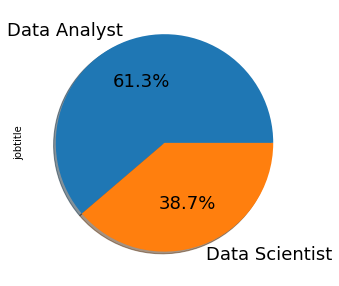

In [9]:
# plot
fig, ax = plt.subplots(figsize = (5,5))
labels = 'Data Analyst', 'Data Scientist'
ax = joblabels['jobtitle'].plot.pie(subplots = True, labels = labels, autopct = '%1.1f%%', shadow = True, fontsize = 18)
plt.show()

This dataset is imbalanced, having more data analyst job descriptions than data scientist job descriptions. This is the result of more data analyst job postings than data scientist postings.

### Job Titles

The job titles are described by other words to specify the field in which the job position will be in. First, we will simplify the job titles for improved aggregation.

In [10]:
# define a function to simplify job titles

data_df["position"] = data_df["jobtitle"].apply(lambda x: x.lower())
    
data_df.loc[data_df["position"].str.contains("analyst"), "position2"] = "Analyst"
data_df.loc[data_df["position"].str.contains("analytic"), "position2"] = "Analyst"
data_df.loc[data_df["position"].str.contains("business intelligence"), "position2"] = "Business Intelligence"
data_df.loc[data_df["position"].str.contains("bi"), "position2"] = "Business Intelligence"
data_df.loc[data_df["position"].str.contains("machine learning"), "position2"] = "Data Scientist"
data_df.loc[data_df["position"].str.contains("scientist"), "position2"] = "Data Scientist"
data_df.loc[data_df["position"].str.contains("data science"), "position2"] = "Data Scientist"
data_df.loc[data_df["position"].str.contains("engineer"), "position2"] = "Data Engineer"

data_df.head()

,jobtitle,company,location,salary,jobdescription,label,position,position2
0,Pricing Analyst,Day & Ross Inc.,"Mississauga, ON",NaN,Position Title:Pricing Analyst Position Type: ...,0,pricing analyst,Analyst
1,Senior Data Analyst- Telephony Manager,NCRi Inc.,"Mississauga, ON",NaN,Title: Senior Data Analyst - Telephony Manager...,0,senior data analyst- telephony manager,Analyst
2,Fuel Cell Data Engineer / Analyst,Cummins Inc.,"Mississauga, ON",NaN,We are looking for a talented Fuel Cell Data E...,0,fuel cell data engineer / analyst,Data Engineer
3,Senior Meter Data Analyst,Rodan Energy Solutions Inc.,"Mississauga, ON",NaN,CAREER OPPORTUNITY SENIOR METER DATA ANALYST L...,0,senior meter data analyst,Analyst
4,"Data Engineer, Business Intelligence & Analytics",Herjavec Group,"Toronto, ON",NaN,The Data Engineer reports directly to the Dire...,0,"data engineer, business intelligence & analytics",Data Engineer


In [11]:
jobtitle = data_df.groupby(["position2"]).count().sort_values(by=["position2"], ascending=False)

jobtitle.head()

,jobtitle,company,location,salary,jobdescription,label,position
position2,,,,,,,
Data Scientist,139,139,139,139,139,139,139
Data Engineer,41,41,41,41,41,41,41
Business Intelligence,63,63,63,63,63,63,63
Analyst,384,384,384,384,384,384,384


In [12]:
data_df["position2"].isna().sum()

8

In [13]:
data_df.position2.describe()

count         627
unique          4
top       Analyst
freq          384
Name: position2, dtype: object

In [14]:
null_jobs = data_df.loc[data_df['position2'].isna()]
null_jobs

,jobtitle,company,location,salary,jobdescription,label,position,position2
23,Data Visualization Specialist,Mainstreet Research,"Toronto, ON",$40 an hour,ROLE:Our diverse team is growing and we’re loo...,0,data visualization specialist,NaN
423,Conversation Designers,MSi Corp (Bell Canada),"Toronto, ON",$50 an hour,"Our Telecom client, Bell Canada, is looking fo...",1,conversation designers,NaN
430,EMM Specialist,Compugen Inc,"Richmond Hill, ON",NaN,Compugen is one of Canada's top Information Te...,1,emm specialist,NaN
473,Epidemiologist - Predictive Modeling Specialist,BlueDot Inc.,"Toronto, ON",NaN,We currently require a full-time predictive mo...,1,epidemiologist - predictive modeling specialist,NaN
486,"Senior Consultant, Cyber Security, Omnia AI",Deloitte,"Toronto, ON",NaN,"Job Type: Permanent Primary Location: Toronto,...",1,"senior consultant, cyber security, omnia ai",NaN
510,Messaging Specialist,Drake International Inc,"Richmond Hill, ON",NaN,Role Description: The Messaging Specialist wil...,1,messaging specialist,NaN
517,"Manager, Cyber Security, Omnia AI",Deloitte,"Toronto, ON",NaN,"Job Type: Permanent Primary Location: Toronto,...",1,"manager, cyber security, omnia ai",NaN
589,NLP Consultant,Prodigy Systems Inc.,"Toronto, ON",$60 - $90 an hour,Practical experience in NLPExperience in devel...,1,nlp consultant,NaN


After simplifying the job titles, there were 8 jobs that did not fall into any of the categories. These are specialist positions.

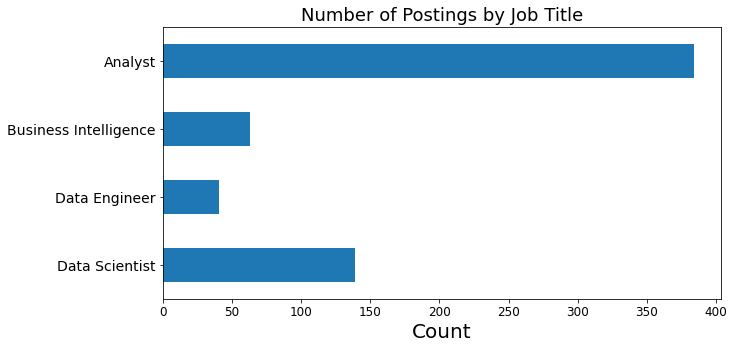

In [15]:
# Plot job titles
jobtitle['position'].plot(kind='barh',figsize = (10,5))
plt.xlabel('Count', size = 20)
plt.ylabel('')
plt.yticks(size = 14)
plt.xticks(size = 12)
plt.title('Number of Postings by Job Title', size = 18)
plt.show()

In [16]:
def group_stats(col):
    '''Function to group data by column and calculate percentage of value counts'''
    return data_df.groupby('label')[col].value_counts(normalize=True).mul(100).rename('percent').reset_index()

In [17]:
jobtitle2 = group_stats('position2')
jobtitle2

,label,position2,percent
0,0,Analyst,85.567010
1,0,Business Intelligence,12.628866
2,0,Data Engineer,1.030928
3,0,Data Scientist,0.773196
4,1,Data Scientist,56.903766
5,1,Analyst,21.757322
6,1,Data Engineer,15.481172
7,1,Business Intelligence,5.857741


In [18]:
# define a function to plot grouped data by position type
def group_barplot(data, col):
    g = sns.catplot(x= 'label', y = 'percent', data= data, hue= col, kind= 'bar', legend=False)
    plt.xticks(ticks=[0,1], labels= ['Data Analyst', 'Data Scientist'], fontsize=14)
    plt.xlabel("Position Title", fontsize = 14)

    plt.yticks(fontsize = 14)
    plt.ylabel("Percent", fontsize = 14)
    g.ax.set_ylim(0, 90)

    plt.legend(title=None, loc = 0, fontsize = 12)
    return g

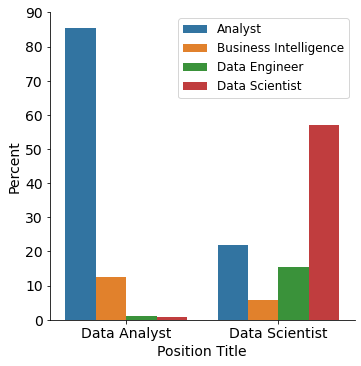

In [19]:
g = group_barplot(jobtitle2, 'position2')

### Job Position Clean-Up

Data used for machine learning could have leakage because of job titles appearing in the search results that do not actually match the desired job position.

To ensure that the job position is exactly what was searched for, any job titles that do not match the intended job title will be removed.

In [20]:
# drop non-Analyst positions from label = 0
data_df.drop(data_df[data_df["position2"] != "Analyst"].index & data_df[data_df['label'] == 0].index, inplace = True)
#data_df.head()

/var/folders/nx/ng8f1kmx73bfpg9ftm8kz5b80000gn/T/ipykernel_7760/3250795064.py:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  data_df.drop(data_df[data_df["position2"] != "Analyst"].index & data_df[data_df['label'] == 0].index, inplace = True)


In [21]:
# drop non-Data Scientist positions from label = 1
data_df.drop(data_df[data_df["position2"] != "Data Scientist"].index & data_df[data_df['label'] == 1].index, inplace = True)
data_df.head()

/var/folders/nx/ng8f1kmx73bfpg9ftm8kz5b80000gn/T/ipykernel_7760/2495728446.py:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  data_df.drop(data_df[data_df["position2"] != "Data Scientist"].index & data_df[data_df['label'] == 1].index, inplace = True)


,jobtitle,company,location,salary,jobdescription,label,position,position2
0,Pricing Analyst,Day & Ross Inc.,"Mississauga, ON",NaN,Position Title:Pricing Analyst Position Type: ...,0,pricing analyst,Analyst
1,Senior Data Analyst- Telephony Manager,NCRi Inc.,"Mississauga, ON",NaN,Title: Senior Data Analyst - Telephony Manager...,0,senior data analyst- telephony manager,Analyst
3,Senior Meter Data Analyst,Rodan Energy Solutions Inc.,"Mississauga, ON",NaN,CAREER OPPORTUNITY SENIOR METER DATA ANALYST L...,0,senior meter data analyst,Analyst
6,"Data Analyst, Digital Marketing",Banque Laurentienne,"Toronto, ON",NaN,"Description de l'emploi Founded in 1846, Laure...",0,"data analyst, digital marketing",Analyst
7,Standards Analyst,docbraces - Canadian Orthodontic Partners,"Etobicoke, ON",NaN,Canadian Orthodontic Partners has an exciting ...,0,standards analyst,Analyst


In [22]:
data_df.describe()

,label
count,468.000000
mean,0.290598
std,0.454524
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Removing the non-matching job titles reduced the number of data points from 635 to 468.

### Level of Seniority

In [23]:
# Level of seniority
data_df.loc[data_df["position"].str.contains(r'intern|student'), "level"] = "Intern"
data_df.loc[data_df["position"].str.contains("junior"), "level"] = "Junior"
data_df.loc[data_df["position"].str.contains("senior"), "level"] = "Senior"
data_df.loc[data_df["position"].str.contains("manager"), "level"] = "Manager"
data_df.loc[data_df["position"].str.contains("director"), "level"] = "Director"

data_df.level.fillna("Unspecified", inplace=True)

data_df.head()

,jobtitle,company,location,salary,jobdescription,label,position,position2,level
0,Pricing Analyst,Day & Ross Inc.,"Mississauga, ON",NaN,Position Title:Pricing Analyst Position Type: ...,0,pricing analyst,Analyst,Unspecified
1,Senior Data Analyst- Telephony Manager,NCRi Inc.,"Mississauga, ON",NaN,Title: Senior Data Analyst - Telephony Manager...,0,senior data analyst- telephony manager,Analyst,Manager
3,Senior Meter Data Analyst,Rodan Energy Solutions Inc.,"Mississauga, ON",NaN,CAREER OPPORTUNITY SENIOR METER DATA ANALYST L...,0,senior meter data analyst,Analyst,Senior
6,"Data Analyst, Digital Marketing",Banque Laurentienne,"Toronto, ON",NaN,"Description de l'emploi Founded in 1846, Laure...",0,"data analyst, digital marketing",Analyst,Unspecified
7,Standards Analyst,docbraces - Canadian Orthodontic Partners,"Etobicoke, ON",NaN,Canadian Orthodontic Partners has an exciting ...,0,standards analyst,Analyst,Unspecified


In [24]:
joblevel = group_stats('level')
joblevel

,label,level,percent
0,0,Unspecified,79.216867
1,0,Senior,15.662651
2,0,Intern,2.409639
3,0,Junior,1.506024
4,0,Manager,0.903614
5,0,Director,0.301205
6,1,Unspecified,69.852941
7,1,Senior,11.764706
8,1,Manager,7.352941
9,1,Junior,4.411765


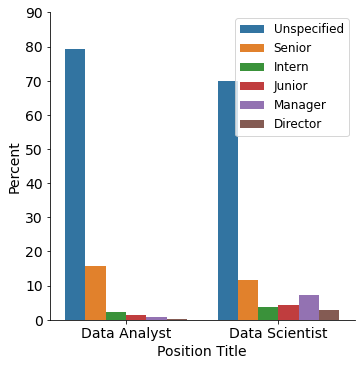

In [25]:
g = group_barplot(joblevel, 'level')
g

### Company

In [26]:
# Is there a type of company that is looking to hire data candidates than others?
company = data_df.groupby(["company"]).count().sort_values('position', ascending=False).head(20)
company.jobtitle

company
BMO Financial Group                      19
Scotiabank                               12
Procom                                   12
Rogers Communications                     7
TD Bank                                   7
RBC                                       7
Johnson & Johnson Family of Companies     6
CIBC                                      6
Bell Canada                               6
Aviva                                     5
Sun Life Financial                        5
IQ Hunt                                   4
Wattpad                                   4
Citi                                      4
Moneris Solutions Corporation             4
Cognizant Technology Solutions            4
Aston Carter                              3
TalentSphere Staffing Solutions           3
Canada Life Assurance Company             3
Deloitte                                  3
Name: jobtitle, dtype: int64

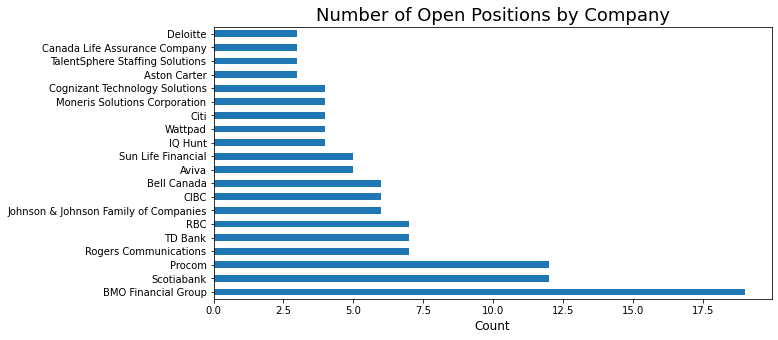

In [27]:
company['position'].plot(kind='barh',figsize = (10,5))
plt.xlabel('Count', size = 12)
plt.ylabel('')
plt.yticks(size = 10)
plt.xticks(size = 10)
plt.title('Number of Open Positions by Company', size = 18)
plt.show()

It appears that banks and communication/tech companies are among the top companies that were hiring candidates.
- Procom is a talent acquisition company
- Aviva is an insurance company
- Johnson & Johnson is a healthcare company
- Wattpad is a platform that hosts user-created stories
- Deloitte is a consulting firm
- IQ Hunt is a contract organization for IT projects
- Cognizant Technology Solutions provides digital solutions for businesses

In [28]:
#company2 = data_df.groupby('label')['company'].value_counts(normalize = True)
company2 = group_stats('company')
company2

,label,company,percent
0,0,BMO Financial Group,4.518072
1,0,Procom,3.012048
2,0,Scotiabank,2.409639
3,0,Johnson & Johnson Family of Companies,1.807229
4,0,Rogers Communications,1.506024
...,...,...,...
323,1,YORKVILLE UNIVERSITY & TORONTO FILM SCHOOL,0.735294
324,1,Zynga,0.735294
325,1,autoTRADER.ca,0.735294
326,1,nugget.ai,0.735294


In [29]:
# top 10 companies for each group
top10_analyst = company2.groupby('label').get_group(0)[:10]
top10_analyst

,label,company,percent
0,0,BMO Financial Group,4.518072
1,0,Procom,3.012048
2,0,Scotiabank,2.409639
3,0,Johnson & Johnson Family of Companies,1.807229
4,0,Rogers Communications,1.506024
5,0,TD Bank,1.506024
6,0,CIBC,1.204819
7,0,Citi,1.204819
8,0,Cognizant Technology Solutions,1.204819
9,0,IQ Hunt,1.204819


In [30]:
top10_scientist = company2.groupby('label').get_group(1)[:10]
top10_scientist

,label,company,percent
233,1,Aviva,3.676471
234,1,Bell Canada,3.676471
235,1,BMO Financial Group,2.941176
236,1,Scotiabank,2.941176
237,1,RBC,2.205882
238,1,Square,2.205882
239,1,Yelp,2.205882
240,1,BDO,1.470588
241,1,Blockthrough,1.470588
242,1,CIBC,1.470588


Graph top 10 of each class side by side.

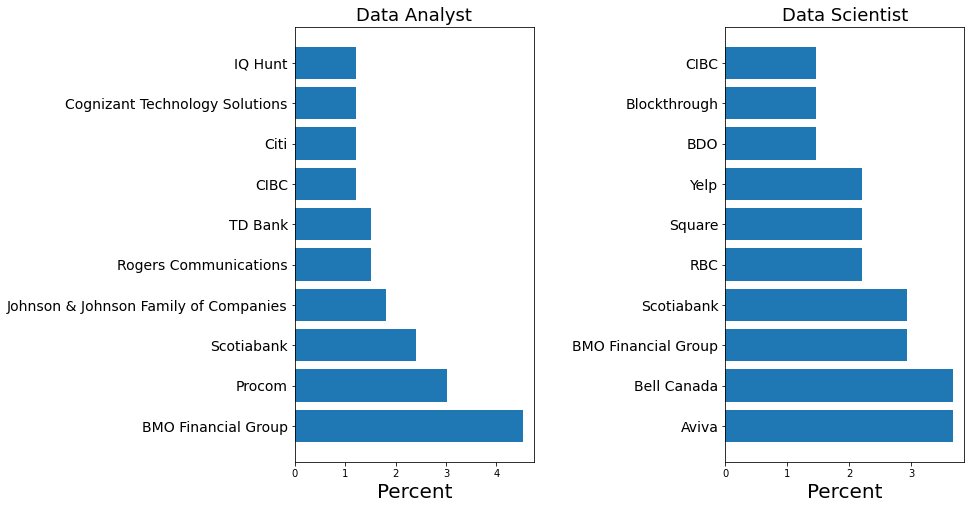

In [31]:
fig = plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.barh(top10_analyst['company'], top10_analyst['percent'])
plt.title("Data Analyst", fontsize=18)
plt.yticks(top10_analyst['company'], fontsize=14)
plt.xlabel('Percent', fontsize=20)

plt.subplot(1, 2, 2)
plt.barh(top10_scientist['company'], top10_scientist['percent'])
plt.title("Data Scientist", fontsize=18)
plt.yticks(top10_scientist['company'], fontsize=14)
plt.xlabel('Percent', fontsize=20)

plt.subplots_adjust(wspace = 0.8)
plt.show()

Banks rank among the highest companies looking for both data analysts and data scientist.
In the top 10, insurance companies appear twice for data scientists and not at all in data analyst.

### Salary

Next, we will look at the distribution of available salaries. There are many salaries that are not provided in the salary section of the job posting.

In [32]:
# Count the number of salaries available with .describe()
data_df["salary"].describe()

count     468
unique     59
top       NaN
freq      393
Name: salary, dtype: object

In [33]:
# Find jobs that include salary information
salary_df = data_df.loc[(data_df.salary != "NaN") & (data_df.salary.str.contains('\d+'))]
salary_df.head(10)

,jobtitle,company,location,salary,jobdescription,label,position,position2,level
38,Business Systems Analyst,TO Live,"Toronto, ON","$60,000 - $70,000 a year",Employment Opportunity Business Systems Analy...,0,business systems analyst,Analyst,Unspecified
48,Inventory Planning Analyst,Manpower,"Rexdale, ON",$23 - $25 an hour,Inventory Planning Analyst - Pay rate $23 per ...,0,inventory planning analyst,Analyst,Unspecified
56,"Senior Analyst, Data Visualization and Analytics",Centennial College,"Scarborough, ON",$41.03 - $47.58 an hour,Job Number: J0321-0815 Job Title: Senior Analy...,0,"senior analyst, data visualization and analytics",Analyst,Senior
63,Business Development Analyst,Origin Merchant Partners,"Toronto, ON","$70,000 a year",Origin Merchant Partners is the largest invest...,0,business development analyst,Analyst,Unspecified
66,marketing analyst,Winful Seafood International Ltd.,"Scarborough, ON",$35 - $38 an hour,Business Equipment and Computer Applications M...,0,marketing analyst,Analyst,Unspecified
69,Research Analyst,North York General Hospital,"Toronto, ON",$25.36 - $30.56 an hour,Company Bio IMAGINE a hospital where everyone ...,0,research analyst,Analyst,Unspecified
73,NEGOTIATIONS ANALYST,Ministry of Health,"Toronto, ON","$63,890 - $89,324 a year","The Ontario Health Insurance Plan Division, Mi...",0,negotiations analyst,Analyst,Unspecified
77,Data Analyst,Parmida E-commerce,"Toronto, ON","$45,000 a year","What we doAt Parmida LED Technologies, we are ...",0,data analyst,Analyst,Unspecified
88,DAX Senior Business Analyst,Flexstaf I.T. Inc.,"Mississauga, ON","$100,000 a year",Position: DAX Senior Business AnalystDuration:...,0,dax senior business analyst,Analyst,Senior
90,Waste Management Analyst,City of Richmond Hill,"Richmond Hill, ON",$40.65 - $47.82 an hour,Posting Id 622 Department Community Services ...,0,waste management analyst,Analyst,Unspecified


In [34]:
def get_salary(amount):
    '''Return salary in a per year amount.'''
    
    if "an hour" in amount:
        if "-" in amount:
            amt_split = amount.replace(' an hour', '').replace('$', '').split(' - ') # returns list
            for i, num in enumerate(amt_split):
                amt_split[i] = (float(num)) * 40 * 52
            return amt_split[0]
        else:
            amt_split = amount.replace(' an hour', '').replace('$', '')
            amt_split = (float(amt_split)) * 40 * 52
            return amt_split
    
    if "a year" in amount:
        if "-" in amount:
            amt_split = amount.replace(' a year', '').replace(',', '').replace('$', '').split(' - ')
            for i, num in enumerate(amt_split):
                amt_split[i] = float(num)
            return amt_split[0]
        else:
            amt_split = amount.replace(' a year', '').replace(',', '').replace('$', '')
            amt_split = float(amt_split)
            return amt_split
    
    if "a day" in amount:
        if "-" in amount:
            amt_split = amount.replace(' a day', '').replace('$', '').split(' - ') # returns list
            for i, num in enumerate(amt_split):
                amt_split[i] = (float(num)) * 5 * 52
            return amt_split[0]
        else:
            amt_split = amount.replace(' a day', '').replace('$', '')
            amt_split = (float(amt_split)) * 5 * 52
            return amt_split

In [35]:
salary_df['yearly_salary ($)'] = salary_df['salary'].map(get_salary)
salary_df.head()

/var/folders/nx/ng8f1kmx73bfpg9ftm8kz5b80000gn/T/ipykernel_7760/2972147010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_df['yearly_salary ($)'] = salary_df['salary'].map(get_salary)


,jobtitle,company,location,salary,jobdescription,label,position,position2,level,yearly_salary ($)
38,Business Systems Analyst,TO Live,"Toronto, ON","$60,000 - $70,000 a year",Employment Opportunity Business Systems Analy...,0,business systems analyst,Analyst,Unspecified,60000.0
48,Inventory Planning Analyst,Manpower,"Rexdale, ON",$23 - $25 an hour,Inventory Planning Analyst - Pay rate $23 per ...,0,inventory planning analyst,Analyst,Unspecified,47840.0
56,"Senior Analyst, Data Visualization and Analytics",Centennial College,"Scarborough, ON",$41.03 - $47.58 an hour,Job Number: J0321-0815 Job Title: Senior Analy...,0,"senior analyst, data visualization and analytics",Analyst,Senior,85342.4
63,Business Development Analyst,Origin Merchant Partners,"Toronto, ON","$70,000 a year",Origin Merchant Partners is the largest invest...,0,business development analyst,Analyst,Unspecified,70000.0
66,marketing analyst,Winful Seafood International Ltd.,"Scarborough, ON",$35 - $38 an hour,Business Equipment and Computer Applications M...,0,marketing analyst,Analyst,Unspecified,72800.0


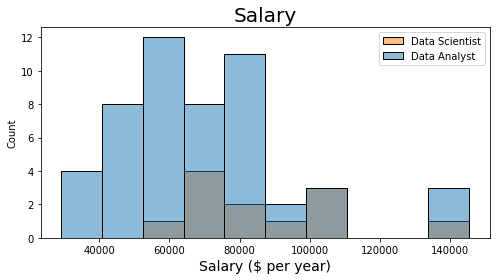

In [36]:
# plot available salaries
fig, ax = plt.subplots(1, 1, figsize=(7,4))
sns.histplot(data = salary_df, x= "yearly_salary ($)", hue = 'label')
plt.title("Salary", fontsize = 20)
plt.xlabel("Salary ($ per year)", fontsize = 14)
plt.ylabel("Count")
plt.legend(labels=["Data Scientist", "Data Analyst"])
plt.tight_layout()
plt.show()

Data scientist salaries are less spread out than data analyst salaries, but surprisingly there are some analyst salaries that are as equally high-paying. As seen below, these high-paying analyst roles are found in the finance sector.

In [37]:
over100 = salary_df[salary_df['yearly_salary ($)'] > 100000].sort_values(by='yearly_salary ($)')
over100

,jobtitle,company,location,salary,jobdescription,label,position,position2,level,yearly_salary ($)
111,Pega Business Analyst,PROVISION IT RESOURCES,"Toronto, ON",$50 - $75 an hour,Here are job details: Business AnalystWFH (Tor...,0,pega business analyst,Analyst,Unspecified,104000.0
416,Data Analytical Scientist,Samiti Technology,"Toronto, ON",$50 - $60 an hour,Samiti Technology Company is actively seeking ...,1,data analytical scientist,Data Scientist,Unspecified,104000.0
515,Career Coaching Mentor - Business/UI/UX Design...,Power Career Education and Technology Inc.,"Toronto, ON",$50 - $51 an hour,"Here at PowerCareer, we believe everyone has w...",1,career coaching mentor - business/ui/ux design...,Data Scientist,Unspecified,104000.0
620,Data Scientist,Dawn InfoTek Inc.,"Toronto, ON",$50 - $60 an hour,Dawn InfoTek Inc. is a professional IT consult...,1,data scientist,Data Scientist,Unspecified,104000.0
135,Data Analyst - SAS Programming - $52.00 p/h - ...,CorGTA,"Toronto, ON",$52 an hour,Role: Data Analyst - SAS DevelopmentStructure:...,0,data analyst - sas programming - $52.00 p/h - ...,Analyst,Unspecified,108160.0
501,Senior Technical Product Manager (Machine Lear...,Brainmaven Corp,"Toronto, ON","$140,000 a year",Senior Technical Product Manager (Machine Lear...,1,senior technical product manager (machine lear...,Data Scientist,Manager,140000.0
176,Business Analyst - Data Architecture,Aston Carter,"Toronto, ON",$67.50 an hour,Equivalent Experience Description: Our client...,0,business analyst - data architecture,Analyst,Unspecified,140400.0
334,Business Analyst - Capital Markets,PROVISION IT RESOURCES,"Toronto, ON",$70 - $80 an hour,Here are job detailsBusiness AnalystWFH (Toron...,0,business analyst - capital markets,Analyst,Unspecified,145600.0
365,Business Analyst/BSA - Wall Street FX,PROVISION IT RESOURCES,"Toronto, ON",$70 - $75 an hour,Must Have Skills: 1. 1 Year (recent project) m...,0,business analyst/bsa - wall street fx,Analyst,Unspecified,145600.0


In [38]:
salary_df.groupby('label').count()

,jobtitle,company,location,salary,jobdescription,position,position2,level,yearly_salary ($)
label,,,,,,,,,
0,51,51,51,51,51,51,51,51,51
1,12,12,12,12,12,12,12,12,12


Overall, only 51 data analyst and 12 data scientist roles included a salary.

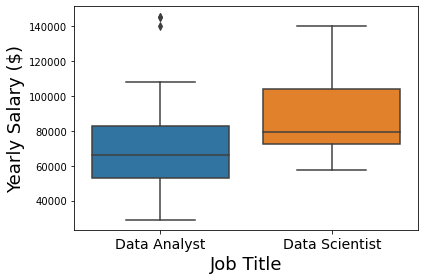

In [39]:
# Create boxplot
g = sns.boxplot(x='label', y="yearly_salary ($)", data=salary_df)
#plt.title("Mean Salary", fontsize = 20)
plt.xlabel("Job Title", fontsize = 18)
plt.xticks([0,1],["Data Analyst", "Data Scientist"], fontsize = 14)
plt.ylabel("Yearly Salary ($)", fontsize = 18)
plt.tight_layout()
plt.show()

In [40]:
mean_salary = salary_df.groupby('label')["yearly_salary ($)"].mean()
pd.DataFrame(mean_salary).reset_index()

,label,yearly_salary ($)
0,0,71697.078431
1,1,87173.016667


In [41]:
import scipy
scipy.stats.ttest_ind(salary_df[salary_df['label'] == 0].get("yearly_salary ($)"), 
salary_df[salary_df['label'] == 1].get("yearly_salary ($)"),
equal_var = False)

Ttest_indResult(statistic=-2.0593195450087864, pvalue=0.05429375010939262)

With a p-value slightly greater than 0.5, the unequal variance unpaired t-test results in accepting the null hypothesis. The mean salary is not statistically significant between data analyts and data scientists.

There were only 12 data scientist jobs where the salary was listed and likely not enough data to demonstrate whether the two salaries and significantly different.

## Skills

From the job descriptions, we can extract the skill requirements to determine which skills are being looked for by employers.

#### Pattern Testing

First, start off testing out a few regular expression patterns.

In [42]:
# use a few text test cases. Include R to ensure 
text2 = 'reports Collaborate with the Finance department and the Sales team to determine prices for new and existing products R powerbi Create profitability reports for upper management, highlighting which products or customers provide the highest profits for the companyDevelop and drive comprehensive pricing strategies and optimization tactics to improve profitability across the product portfolioEnsure all reporting procedures are suitably documentedEnsure accuracy of pricing dataRecommend changes in pricing as profitableUpdate pricing information in excel spreadsheetsConduct and execute special projects and ad hoc reports as requiredSetup and coordinate to maintain a price structure with FinanceUpdating existing price structure for new and existing customersPerforms other duties as assignedKnowledge: Knowledge of bearing part numbers or external market bearing knowledgeMust have knowledge of gross and profit marginsPrior Knowledge and ability to work with JDE 9.2 Advanced Pricing (asset)Skills and Abilities: Excellent communication skills, both strong written and verbal in English and in FrenchAdvanced in MS Excel including PivotTables, VLOOKUP, formulas, graphsMust be able to create Macros in excelProficient MS Office skills with an emphasis on Word and PowerpointMust be able to analyze large amount of data using excelDetail oriented with the ability to problem solveAbility to work independently with minimal supervisionExtremely organized, able to multi-task, and prioritize projectsAbility'
text3 = 'blah blah blah power BI and R programming'

pattern_obj = '(?i)\\bExcel\\b'
pattern_object = re.compile(pattern_obj)

# pattern_obj = '(?i)Power\s?BI'
# pattern_object = re.compile(pattern_obj)

skill_count = 0
if pattern_object.search(text2):
    skill_count += 1
    print(skill_count)
else:
    print("Skill not found")

1


Create dictionary for each job class to hold the number of job descriptions for which each skill is listed.

In [43]:
# list of skills to be searched for and the regex patterns to search with
skills = ['R','Python','Java','C','SQL','RedShift','Snowflake','Database',
'Jupyter notebook','Dashboards','Tableau','Power BI','SAS','Excel','Algorithm', 'Statistics',
'Time Series','Visualization','Matplotlib','Seaborn','Plotly','ggplot','machine learning',
'scikit-learn','Spark','Hadoop','Hive','TensorFlow','Keras','Scala','deep learning', 
'AWS','Google Cloud','Automation','Pipelines','Clinical Data','Ad-Hoc','Creativity','research','French']

skill_patt = ['(?i)\\bR\\b','(?i)\\bPython\\b', '(?i)\\bJava\\b', '(?i)\\bC\\b','(?i)\\bSQL\\b','(?i)\\bRedShift\\b','(?i)\\bSnowflake\\b','(?i)\\bDatabase\\b',
'(?i)\\bJupyter\\b','(?i)\\bDashboard\\b','(?i)\\bTableau\\b',"(?i)\\bPower\s?BI\\b",'(?i)\\bSAS\\b','(?i)\\bExcel\\b','(?i)\\bAlgorithm\\b', '(?i)\\bStatistics\\b',
'(?i)\\bTime\sSeries\\b','(?i)\\bVisualization\\b','(?i)\\bMatplotlib\\b',"(?i)\\bSeaborn\\b",'(?i)\\bPlotly\\b','(?i)\\bggplot\\b','(?i)\\bmachine learning\\b',
'(?i)\\bscikit\s?learn\\b|\\bscikit-learn\\b|\\bsk\s?learn\\b', '(?i)\\bSpark\\b','(?i)\\bHadoop\\b?',"(?i)\\bHive\\b","(?i)\\bTensorFlow\\b",'(?i)\\bKeras\\b','(?i)\\bScala\\b','(?i)\\bdeep\slearning\\b',
'(?i)\\bAWS\\b','(?i)\\bGoogle\sCloud\\b','(?i)\\bAutomation\\b','(?i)\\bPipelines\\b','(?i)\\bClinical\sData\\b','(?i)\\bAd-Hoc\\b|\\badhoc\\b|\\bad hoc\\b','(?i)\\bCreativity\\b','(?i)\\bresearch\\b','(?i)\\bFrench\\b']

In [44]:
def count_skill(pattern, text):
    '''Count the number of job descriptions that require a specific skill.
    Save results in dictionary.'''

    skill_count = 0
    pattern_object = re.compile(pattern)
    if pattern_object.search(text):
        skill_count += 1
    return skill_count

In [45]:
# initiate dict to hold counts
skills0_dict = {s: 0 for s in skills}
skills1_dict = {s: 0 for s in skills}

# loop through job description of each row
for index, row in data_df.iterrows():
    if row['label'] == 0:
        for s, p in zip(skills, skill_patt):
            if count_skill(p,row['jobdescription']):
                skills0_dict[s] += 1
    else:
        for s, p in zip(skills, skill_patt):
            if count_skill(p,row['jobdescription']):
                skills1_dict[s] += 1

In [46]:
# class 0 / analyst
skill0_df = pd.DataFrame.from_dict(skills0_dict, orient='index').reset_index()
skill0_df.rename(columns={'index': 'Skill', 0: 'Count'}, inplace=True)
# skill0_df.head()

In [47]:
# class 1 / scientist
skill1_df = pd.DataFrame.from_dict(skills1_dict, orient='index').reset_index()
skill1_df.rename(columns={'index': 'Skill', 0: 'Count'}, inplace=True)
# skill1_df.head()

In [48]:
# normalize data
def calc_pctg(x, df):
    '''Let x equal the number of counts per skill.
    Divide by the total number of jobs in dataset'''
    return round(x/len(df)*100,1)

In [49]:
# Calculate the percentage that each skill appears in all the jobs descriptions in the data set
# class 0 / analyst
skill0_df['Percent'] = skill0_df['Count'].map(lambda x: calc_pctg(x,data_df))
skill0_df.sort_values(by=['Count'], inplace=True, ascending=False)
skill0_df.head(10)

,Skill,Count,Percent
13,Excel,167,35.7
4,SQL,151,32.3
38,research,100,21.4
36,Ad-Hoc,69,14.7
7,Database,65,13.9
10,Tableau,64,13.7
1,Python,63,13.5
17,Visualization,57,12.2
11,Power BI,51,10.9
15,Statistics,48,10.3


In [57]:
analyst_top20 = skill0_df['Skill'][:10]
analyst_top20.to_csv('top10_analyst_skills.csv', index = False)

In [58]:
# class 1 / scientist
skill1_df['Percent'] = skill1_df['Count'].map(lambda x: calc_pctg(x,data_df))

skill1_df.sort_values(by=['Count'], inplace=True, ascending=False)
skill1_df.head(10)

,Skill,Count,Percent
1,Python,108,23.1
22,machine learning,101,21.6
4,SQL,80,17.1
15,Statistics,76,16.2
0,R,69,14.7
38,research,51,10.9
17,Visualization,42,9.0
24,Spark,33,7.1
10,Tableau,31,6.6
25,Hadoop,23,4.9


In [59]:
scientist_top20 = skill1_df['Skill'][:10]
scientist_top20.to_csv('top10_scientist_skills.csv', index = False)

### Create Visualization of top skills

In [60]:
# Generate wordcloud from frequencies
wordcloud_0 = WordCloud(min_font_size=12 ,colormap="Blues")
wordcloud_0.generate_from_frequencies(skills0_dict)

In [61]:
wordcloud_1 = WordCloud(min_font_size=12 ,colormap="Oranges")
wordcloud_1.generate_from_frequencies(skills1_dict)

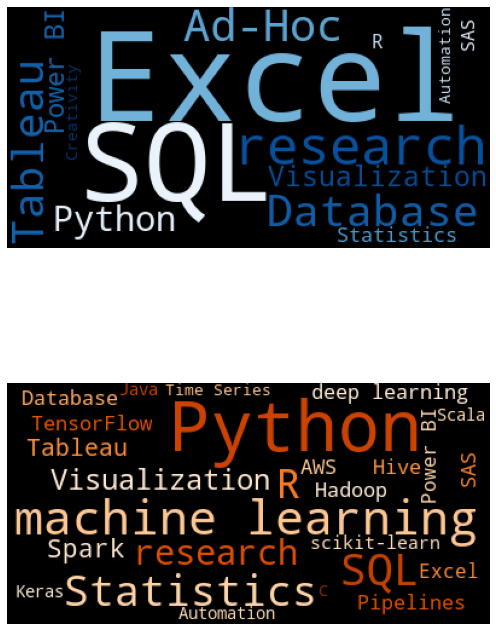

In [62]:
# plot both wordclouds
fig = plt.figure(figsize=(7,12))

fig.add_subplot(2,1,1)
plt.imshow(wordcloud_0)
plt.axis('off')

fig.add_subplot(2,1,2)
plt.imshow(wordcloud_1)
plt.axis("off")
plt.tight_layout()
plt.show()

In this dataset, Data Analyst positions lean toward more database work and reporting with dashboards with tools such as Tableau and Power BI. Although programming languages such as Python and R are indicated for Data Analyst positions, Data Scientist positions are more likely to require programming and indicate that big data tools and advanced machine learning are important.

## Save File

In [54]:
# Save to file
data_df.to_json("cleaned_data.json")
print("Dataframe saved as json file.")

Dataframe saved as json file.
